In [1]:
import numpy as np
from simfloat import *
import matplotlib.pyplot as plt

%matplotlib inline

# 基础研究方法说明

研究目标: 影响向量内积计算的浮点数量化误差的主要因素
LLM中主要的计算是矩阵乘法，而矩阵乘法可以看做是由向量内积构成的，因此我们主要研究：
1. 向量内积的浮点数量化误差受向量长度的影响；
2. 向量相关性对浮点数量化误差的影响；

## SIMFLOAT的使用

### 使用content定义浮点数
浮点数主要由三部分构成：
1. 符号位，通常为1 bit，0表示正数，1表示负数；
2. 指数位 (Exponent)：用于表示数值的量级
3. 尾数位 (Mantissa/Significand)：表示实际的数值精度

常见的浮点数类型的定义：
1. double（float64）：1s 11e 52m
2. single（float32）：1s 8e 23m
3. half（float16）：1s 5e 10m
4. bfloat16：1s 8e 7m

可以使用simfloat自定义一个浮点类型：

In [2]:
ftype = define_context(5, 10)
print(ftype(1.1))
print(ftype(1.1).as_decimal())

0 01111 0001100110
1.099609375


### 使用simfloat进行浮点数运算

我们可以借助simfloat来进行浮点数运算，只需要定义两个浮点数，然后直接进行一些基础运算即可:

In [3]:
ftype = define_context(5, 10)
a = ftype(1.0)
b = ftype(2.0)
print(a+b)
print((a+b).as_decimal())

0 10000 1000000000
3.0


## 向量内积的浮点数量化误差研究方法

1. 通过define_context定义需要的浮点数类型；
2. 通过numpy生成两个随机float64向量；
3. 分别在自定义的浮点类型与float64上计算向量内积，并计算误差的绝对值；

具体代码如下：

In [4]:
def dot_error(scale=0.01, size=100, round_method="ROUND_HALF_UP"):
    ctx = define_context(8, 7, "ROUND_HALF_UP")
    a = np.random.normal(scale=scale, size=[size])
    b = np.random.normal(scale=scale, size=[size])
    A = [ctx(x) for x in a]
    B = [ctx(x) for x in b]
    C = ctx(0)
    for x in [ x*y for x,y in zip(A,B )]:
        C = C+x
    gt = np.dot(a,b)
    ret = float(C.as_decimal())
    return np.abs(ret-gt)

测试一下上述代码，我们通过散点图观察下上述代码的输出：

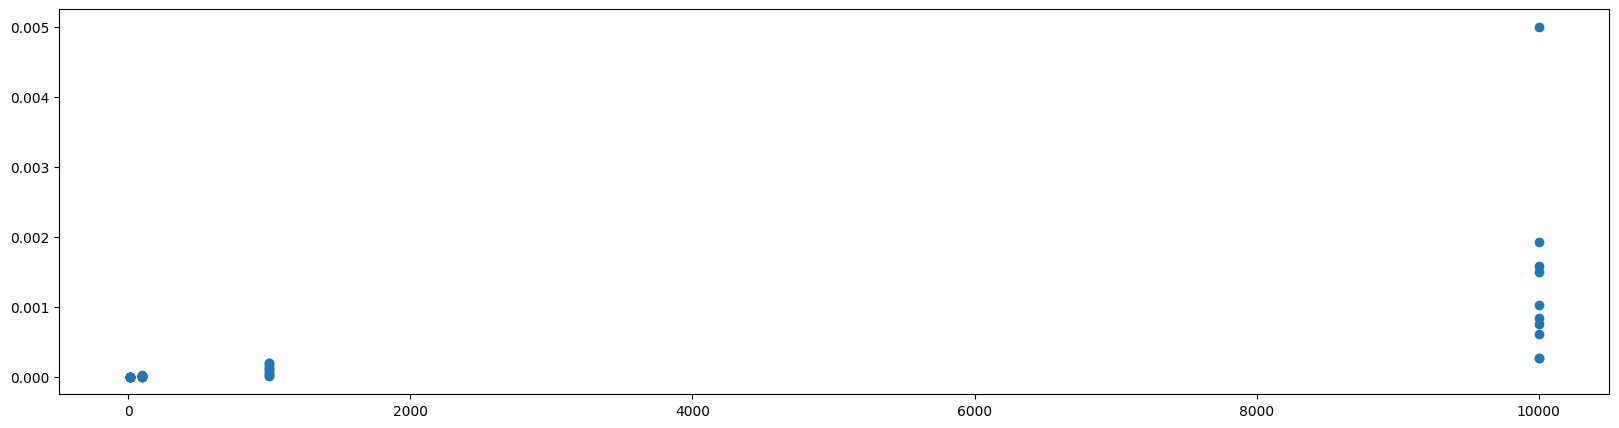

In [5]:
scale = [10, 100, 1000, 10000]*10
plt.figure(figsize=(20,5))
plt.scatter(scale, [dot_error(0.01, s) for s in scale])

借助上述代码，我们很快便发现了浮点数量化误差随着向量长度而增长。由于该误差是一个随机变量，我们可以能通过研究其范围来给出结论。

# 浮点数向量内积计算的量化误差分析

根据前边的分析和说明，我们认为影响量化误差的主要因素有两个：
1. 向量长度，已经在前一节进行了初步验证，本节将进行定性和定量分析；
2. 向量之间的相关性，本节将进行系统性分析；

## 生成两个相关的随机向量

可以通过在第二个向量中混合第一个向量来人为制造相关性，代码如下：

In [6]:
def generate_correlated_vectors_simple(n_dim, scale, rho):
    z1 = np.random.normal(0, scale, (n_dim,))
    z2 = np.random.normal(0, scale, (n_dim,))
    return z1, rho * z1 + (1 - rho) * z2

验证一下该方法的正确性：

In [7]:
a, b = generate_correlated_vectors_simple(1000, 0.1, 0.2)
np.dot(a,b) / np.sqrt( np.dot(a,a) * np.dot(b,b) )

0.23135646685314878

In [8]:
a, b = generate_correlated_vectors_simple(1000, 0.5, 0.03)
np.dot(a,b) / np.sqrt( np.dot(a,a) * np.dot(b,b) )

0.0718090540743797

通过两个测试发现上述方法基本可用，但是相关性误差略高。不过不影响我们得到一些想要的结论。

## 两个向量量化后计算内积的量化误差

In [9]:
def calc_dot_error(a, b, round_method="ROUND_HALF_UP"):
    ctx = define_context(8, 7, round_method)
    A = [ctx(x) for x in a]
    B = [ctx(x) for x in b]
    C = ctx(0)
    for x in [ x*y for x,y in zip(A,B )]:
        C = C+x
    gt = np.dot(a,b)
    ret = float(C.as_decimal())
    return np.abs(ret-gt)

def correlated_dot_error(scale=0.01, size=100, rho=0.1, round_method="ROUND_HALF_UP"):
    a, b = generate_correlated_vectors_simple(size, scale, rho)
    return calc_dot_error(a, b, round_method=round_method)

首先定性分析下向量长度、向量相关性与不同量化方法的影响：

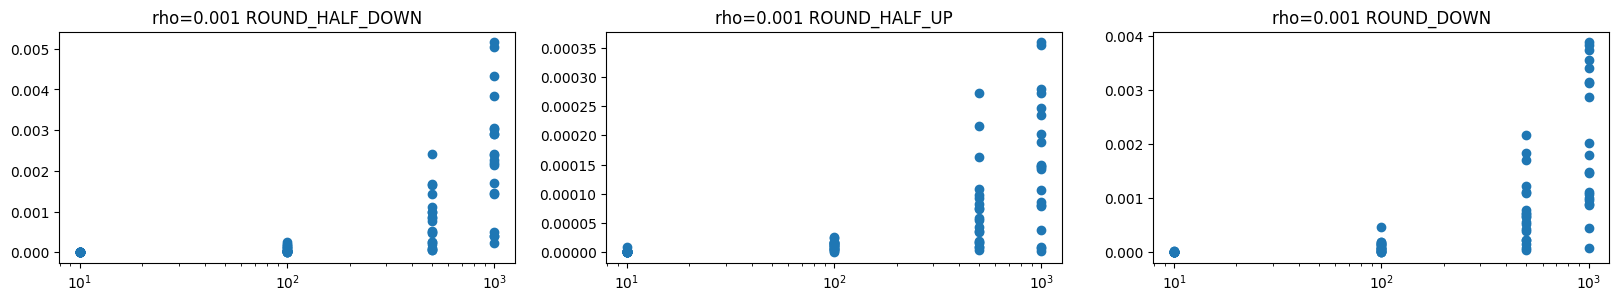

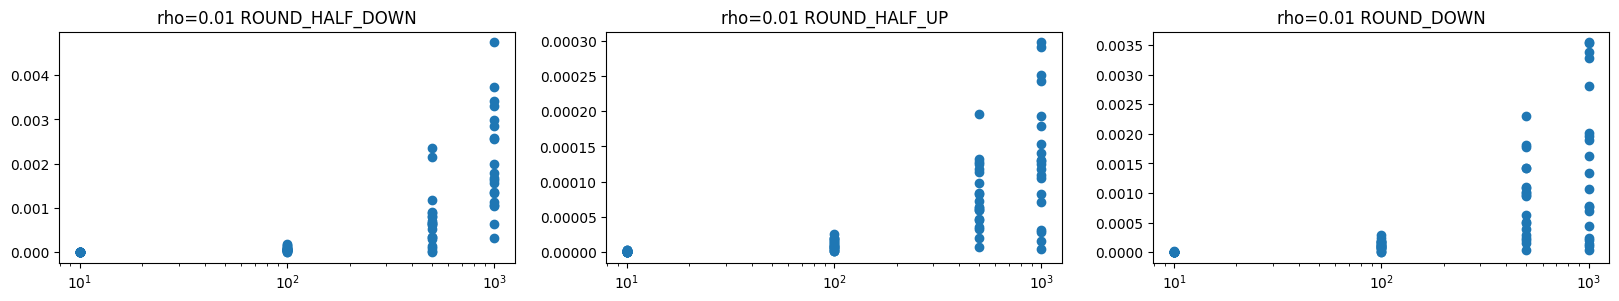

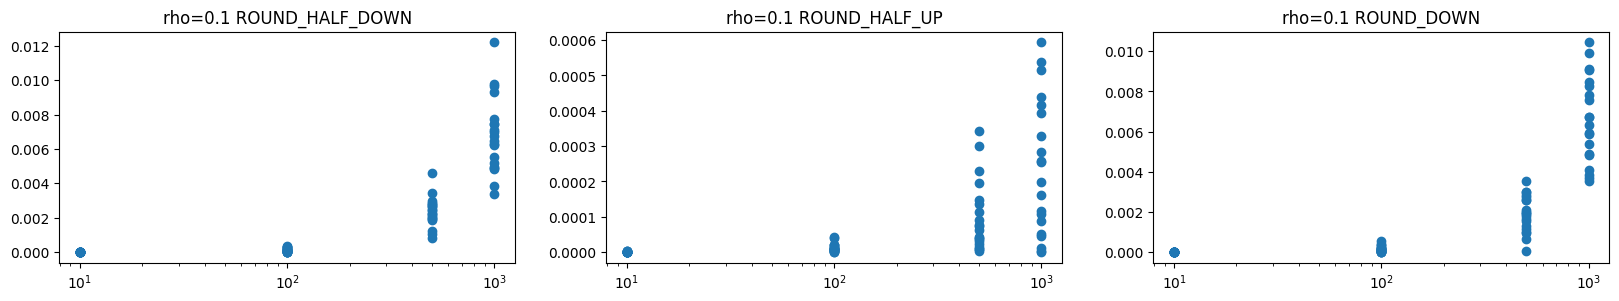

In [12]:
size = [10, 100, 500, 1000]*20
for rho in [0.001, 0.01, 0.1]:
    plt.figure(figsize=(20,3))
    plt.subplot(1,3,1)
    plt.scatter(size, [correlated_dot_error(0.01, s, rho, "ROUND_HALF_DOWN") for s in size], label=f"rho={rho}")
    plt.xscale('log')
    plt.title(f"rho={rho} ROUND_HALF_DOWN")
    
    plt.subplot(1,3,2)
    plt.scatter(size, [correlated_dot_error(0.01, s, rho, "ROUND_HALF_UP") for s in size], label=f"rho={rho}")
    plt.xscale('log')
    plt.title(f"rho={rho} ROUND_HALF_UP")
    
    plt.subplot(1,3,3)
    plt.scatter(size, [correlated_dot_error(0.01, s, rho, "ROUND_DOWN") for s in size], label=f"rho={rho}")
    plt.xscale('log')
    plt.title(f"rho={rho} ROUND_DOWN")
    plt.show()

从散点图上可以看到：
1. 量化误差随向量长度变大而变大；
2. 量化误差随向量相关性变大而变大；
3. 量化方法里，ROUND_HALF_UP(round to nearest even)最好，ROUND_DOWN与ROUND_HALF_DOWN区别不大；

## 统计分析
我们使用箱图来进一步细化刚才的结果。箱图提供了较散点图更加丰富的统计细节：
1. 给出分布的中位数（50%分位点）；
2. 给出分布的主要分布范围（25%分位点到75%分位点）；
3. 给出最大值与最小值的位置（0%分位点与100%分位点）；
由于数据分布中经常存在outlier，常见的boxplot实现会计算IQR（75%~25%的动态范围），并将超出1.5倍IQR的数据点作为野点处理。

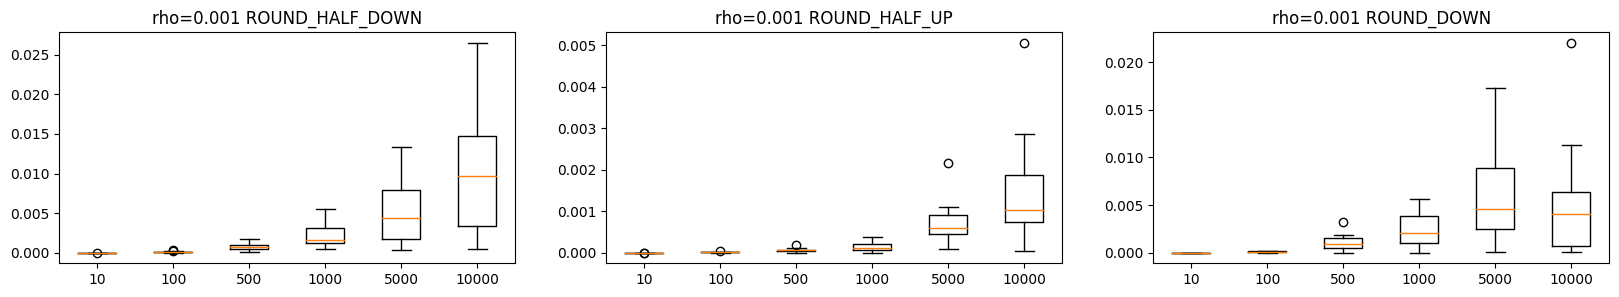

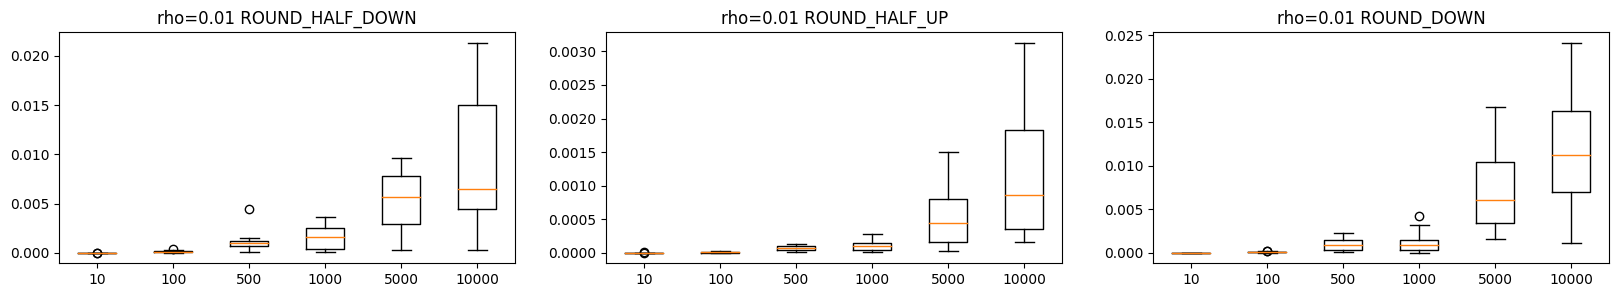

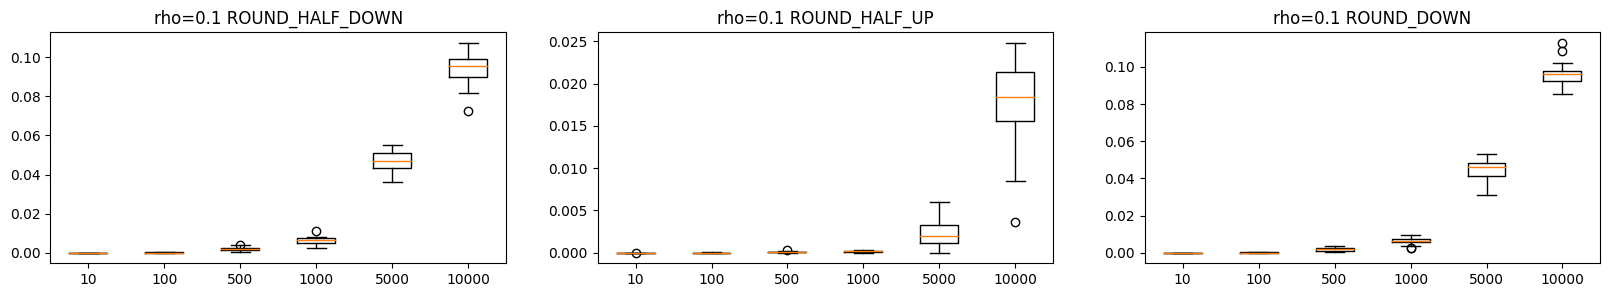

In [13]:
size = [10, 100, 500,1000, 5000, 10000]
samples = 20
for rho in [0.001, 0.01, 0.1]:
    plt.figure(figsize=(20,3))
    plt.subplot(1,3,1)
    plt.boxplot([[correlated_dot_error(0.01, s, rho, "ROUND_HALF_DOWN") for _ in range(samples)] for s in size])
    plt.xticks(ticks=[x+1 for x in range(len(size))],labels=size)
    plt.title(f"rho={rho} ROUND_HALF_DOWN")
    
    plt.subplot(1,3,2)
    plt.boxplot([[correlated_dot_error(0.01, s, rho, "ROUND_HALF_UP") for _ in range(samples)] for s in size])
    plt.xticks(ticks=[x+1 for x in range(len(size))],labels=size)
    plt.title(f"rho={rho} ROUND_HALF_UP")
    
    plt.subplot(1,3,3)
    plt.boxplot([[correlated_dot_error(0.01, s, rho, "ROUND_DOWN") for _ in range(samples)] for s in size])
    plt.xticks(ticks=[x+1 for x in range(len(size))],labels=size)
    plt.title(f"rho={rho} ROUND_DOWN")
    plt.show()

从箱图分析来看，不同量化方法的量化误差相差很大，我们在向量长度为10000的情况下对各种量化方法进行更加详细的测试：

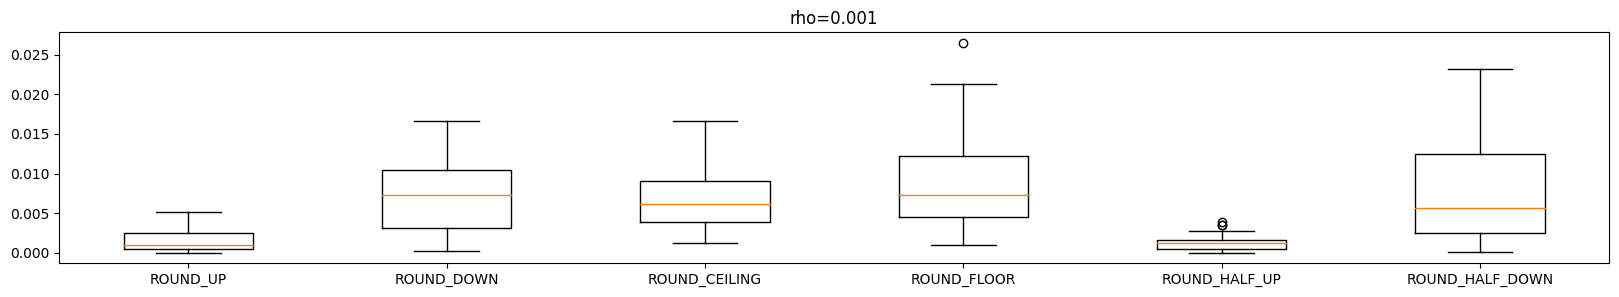

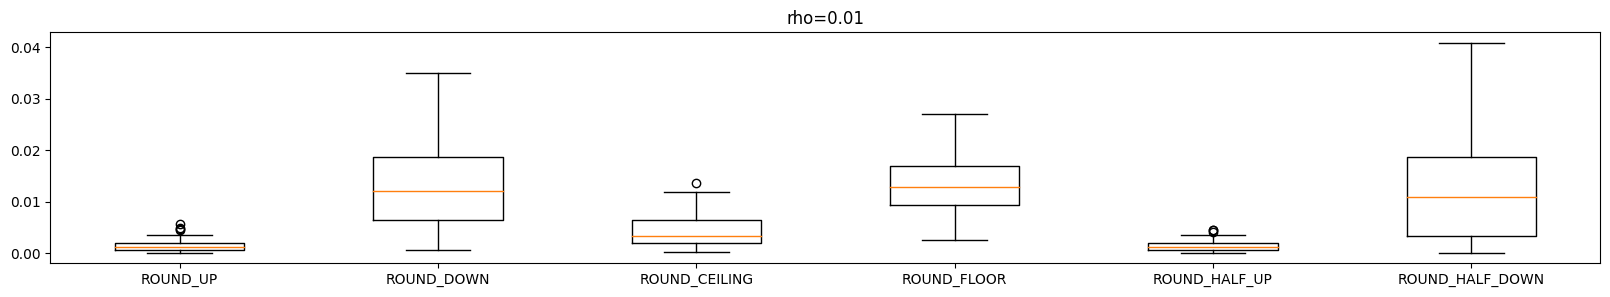

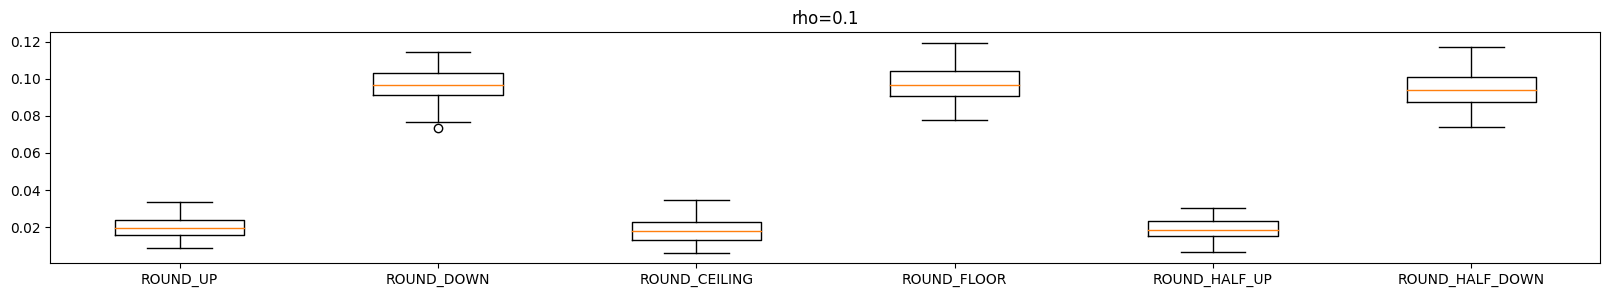

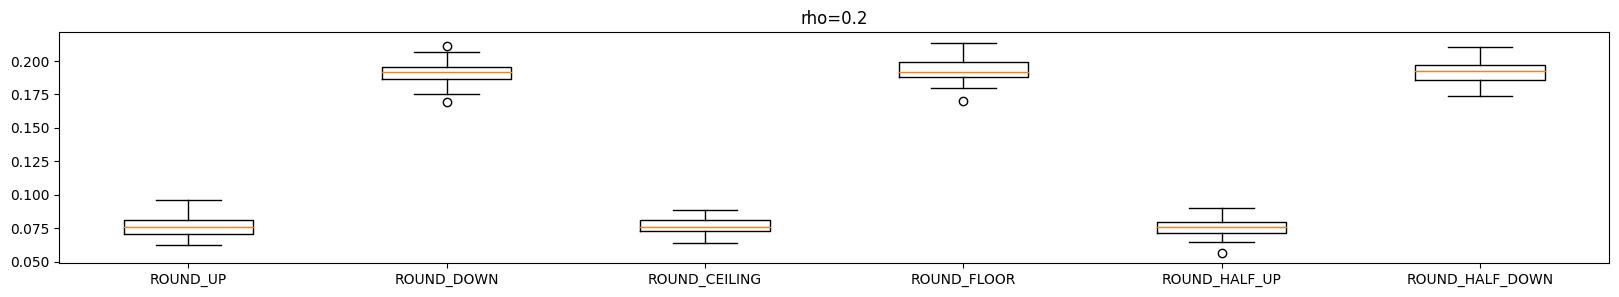

In [14]:
rounds = ["ROUND_UP", "ROUND_DOWN", "ROUND_CEILING", "ROUND_FLOOR", "ROUND_HALF_UP", "ROUND_HALF_DOWN"]
samples = 50
for rho in [0.001, 0.01, 0.1, 0.2]:
    plt.figure(figsize=(20,3))
    plt.boxplot([[correlated_dot_error(0.01, 10000, rho, round) for _ in range(samples)] for round in rounds])
    plt.xticks(ticks=[x+1 for x in range(len(rounds))],labels=rounds)
    plt.title(f"rho={rho}")
    plt.show()

从上述实验可以看到，量化方法分成了两档：
1. ROUND_UP、ROUND_CEILING和ROUND_HALF_UP精度较好，并且受向量相关性影响较小；
2. ROUND_DOWN、ROUND_FLOOR和ROUND_HALF_DOWN精度较差，并且向量相关性越大，量化误差越大；

前者的共性是倾向于进行进位，后者的共性是倾向于进行丢弃尾数。而两者的差异随向量相关性的变大，而更加明显。

## 定量分析

为了更好的研究量化误差的性质，本节将会对ROUND_HALF_UP与ROUND_HALF_DOWN两种量化方法进行定量分析。

#### 量化误差与向量长度的关系

In [15]:
size = [10, 100, 500, 1000, 5000, 10000]
RUP_MED_size = []
RUP_MAX_size = []
RDOWN_MED_size = []
RDOWN_MAX_size = []

nsample = 20

for s in size:
    up_errors = []
    down_errors = []
    for _ in range(nsample):
        a, b = generate_correlated_vectors_simple(s, 0.01, 0.0)
        error = calc_dot_error(a, b, round_method="ROUND_HALF_UP")
        up_errors.append(error)
        error = calc_dot_error(a, b, round_method="ROUND_HALF_DOWN")
        down_errors.append(error)
    RUP_MED_size.append(np.median(up_errors))
    RUP_MAX_size.append(np.max(up_errors))
    RDOWN_MED_size.append(np.median(down_errors))
    RDOWN_MAX_size.append(np.max(down_errors))

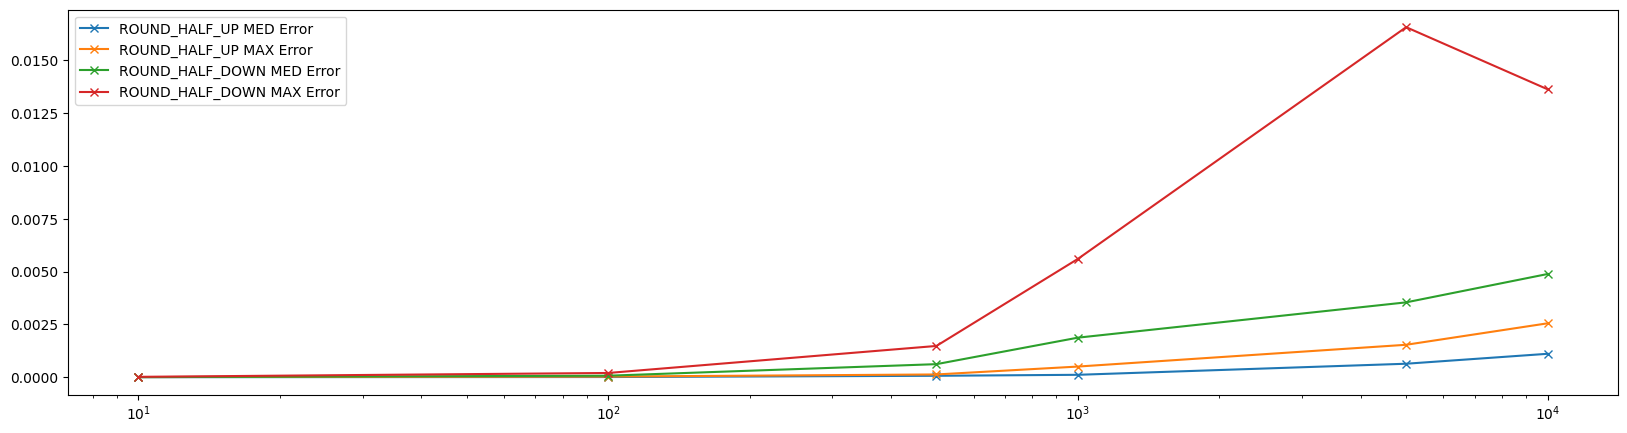

In [16]:
plt.figure(figsize=(20,5))
plt.plot(size, RUP_MED_size, marker='x', label="ROUND_HALF_UP MED Error")
plt.plot(size, RUP_MAX_size, marker='x', label="ROUND_HALF_UP MAX Error")
plt.plot(size, RDOWN_MED_size, marker='x', label="ROUND_HALF_DOWN MED Error")
plt.plot(size, RDOWN_MAX_size, marker='x', label="ROUND_HALF_DOWN MAX Error")
plt.xscale('log')
# plt.yscale('log')
plt.legend()

ROUND_HALF_UP的量化误差近似线性增长，ROUND_HALF_DOWN的量化误差近似指数增长。我们可以进行一个简单的多项式拟合来证明这点：

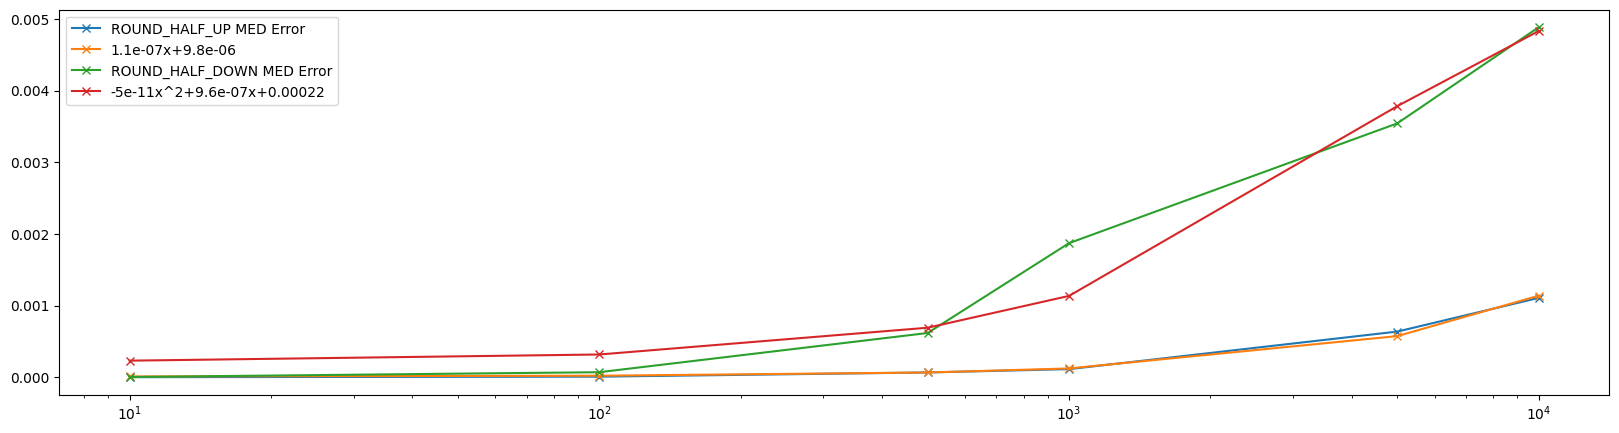

In [17]:
# a, b = np.polyfit(size, RUP_MED_size, 1)
# aa, bb, cc = np.polyfit(size, RDOWN_MED_size, 2)

b, a = np.polynomial.Polynomial.fit(size, RUP_MED_size, 1).convert()
cc, bb, aa = np.polynomial.Polynomial.fit(size, RDOWN_MED_size, 2).convert()

plt.figure(figsize=(20,5))
plt.plot(size, RUP_MED_size, marker='x', label="ROUND_HALF_UP MED Error")
plt.plot(size, [a*x+b for x in size], marker='x', label=f"{a:.2}x+{b:.2}")
plt.plot(size, RDOWN_MED_size, marker='x', label="ROUND_HALF_DOWN MED Error")
plt.plot(size, [aa*x*x+bb*x+cc for x in size], marker='x', label=f"{aa:.2}x^2+{bb:.2}x+{cc:.2}")
plt.xscale('log')
# plt.yscale('log')
plt.legend()

由此可见，ROUND_HALF_DOWN方法的量化误差随着向量长度的增长而（二阶）多项式增长，显著快于ROUND_HALF_UP方法量化误差的线性增长

#### 量化误差与向量相关性的关系

In [18]:
rhos = [0.0, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8]
RUP_MED = []
RUP_MAX = []
RDOWN_MED = []
RDOWN_MAX = []

nsample = 20

for r in rhos:
    up_errors = []
    down_errors = []
    for _ in range(nsample):
        a, b = generate_correlated_vectors_simple(10000, 0.01, r)
        error = calc_dot_error(a, b, round_method="ROUND_HALF_UP")
        up_errors.append(error)
        error = calc_dot_error(a, b, round_method="ROUND_HALF_DOWN")
        down_errors.append(error)
    RUP_MED.append(np.median(up_errors))
    RUP_MAX.append(np.max(up_errors))
    RDOWN_MED.append(np.median(down_errors))
    RDOWN_MAX.append(np.max(down_errors))

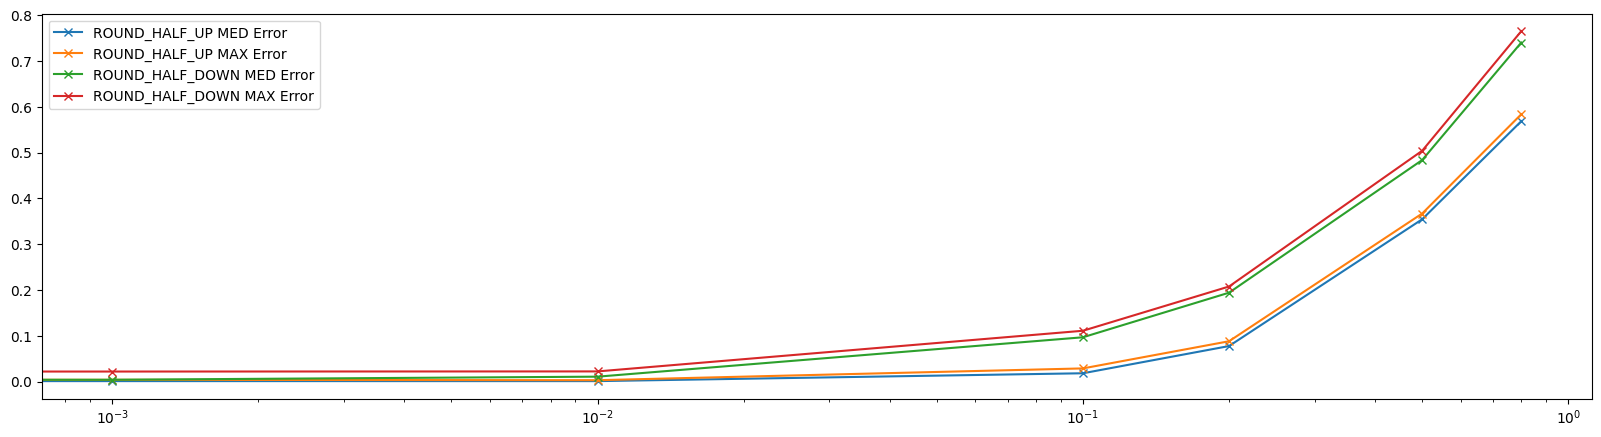

In [19]:
plt.figure(figsize=(20,5))
plt.plot(rhos, RUP_MED, marker='x', label="ROUND_HALF_UP MED Error")
plt.plot(rhos, RUP_MAX, marker='x', label="ROUND_HALF_UP MAX Error")
plt.plot(rhos, RDOWN_MED, marker='x', label="ROUND_HALF_DOWN MED Error")
plt.plot(rhos, RDOWN_MAX, marker='x', label="ROUND_HALF_DOWN MAX Error")
plt.xscale('log')
# plt.yscale('log')
plt.legend()

两种量化方法均随着向量相关性的增加而超线性增长，这里进一步通过多项式拟合的方法研究相关性与量化误差的关系：

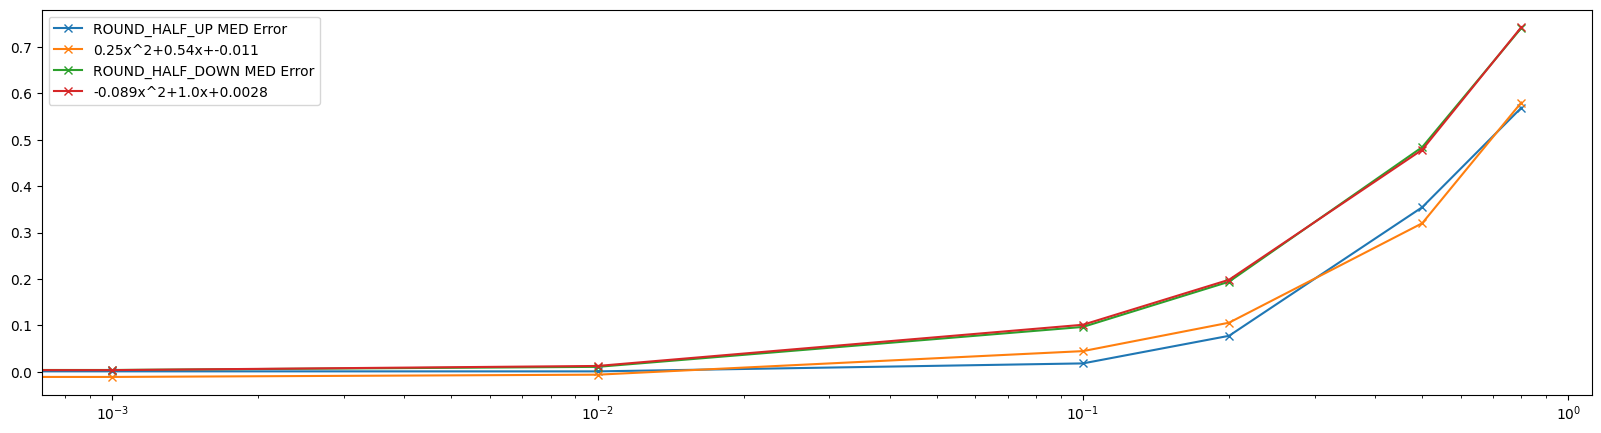

In [20]:
c, b, a = np.polynomial.Polynomial.fit(rhos, RUP_MED, 2).convert()
cc, bb, aa = np.polynomial.Polynomial.fit(rhos, RDOWN_MED, 2).convert()

plt.figure(figsize=(20,5))
plt.plot(rhos, RUP_MED, marker='x', label="ROUND_HALF_UP MED Error")
plt.plot(rhos, [a*x*x+b*x+c for x in rhos], marker='x', label=f"{a:.2}x^2+{b:.2}x+{c:.2}")
plt.plot(rhos, RDOWN_MED, marker='x', label="ROUND_HALF_DOWN MED Error")
plt.plot(rhos, [aa*x*x+bb*x+cc for x in rhos], marker='x', label=f"{aa:.2}x^2+{bb:.2}x+{cc:.2}")
plt.xscale('log')
# plt.yscale('log')
plt.legend()

由上图可见，ROUND_HALF_DOWN和ROUND_HALF_UP方法的量化误差随着向量相关性的增长而（二阶）多项式增长

# 结论
## 主要现象
1. 分析了向量内积计算中的浮点数量化误差问题，发现影响量化误差大小的主要因素有：
   1. 向量长度；
   2. 向量的相关性；
2. 不同量化方法对量化误差的影响不同：
   1. ROUND_HALF_UP (RNE)方法量化误差较小；
   2. ROUND_HALF_DOWN (RN)方法量化误差较大；
3. ROUND_HALF_DOWN等具有舍弃尾数特性的量化方法，量化误差随向量长度（二次）多项式增长；
4. ROUND_HALF_DOWN与ROUND_HALF_UP的量化误差随向量相关性（二次）多项式增长；

## 一些结论

1. 小规模的算子单测误差无法代表大规模的情况；
2. 算子单测应该引入线性相关性，来放大量化误差，这样能更好地定位精度问题；
3. 出于精度考虑，应该选择ROUND_HALF_UP量化方法，出于性能考虑，可以尝试ROUND_UP或者ROUND_CEILING量化方法；